## Implementing UMAP from Scratch

In [71]:
import random

import pandas as pd
import numpy as np
import seaborn as sns

import matplotlib.pyplot as plt

from sklearn.datasets import fetch_openml

import scipy
import scipy.sparse
from scipy.optimize import curve_fit
import numba

from pynndescent import NNDescent

sns.set_theme()
random.seed(2)

### Loading digits datasets

In [72]:
# load the digit data
mnist = fetch_openml('mnist_784', parser='auto')

In [73]:
# Normalize the mnist data
mnist_data = mnist.data/255
mnist_label = mnist.target.astype(object)

In [74]:
# Downsample the data
mnist_label = mnist_label[mnist_label.isin(['0','1','2','3','4'])]
mnist_data = mnist_data.loc[mnist_label.index,:].reset_index(drop=True)

mnist_label = mnist_label.reset_index(drop=True)

In [75]:
# Downsample it to 15k samples as its too much
mnist_data = mnist_data.iloc[:15000]
mnist_label = mnist_label[:15000]

In [76]:
print(mnist_data.shape)
print(mnist_label.shape)

(15000, 784)
(15000,)


In [77]:
mnist_label.unique()

array(['0', '4', '1', '2', '3'], dtype=object)

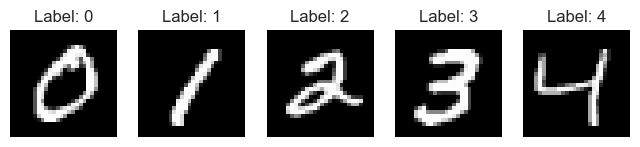

In [78]:
# Initialize the dictionary for first instance 0-4
first_intance = {}

# loop through every instance to find the first 0-4
for i in range(len(mnist_label)):

    label = mnist_label[i]

    if label not in first_intance:
        first_intance[label] = i

# plot the graph
fig, axes = plt.subplots(1, 5, figsize=(8,8))

for label, index in first_intance.items():
    ax = axes[int(label)]
    ax.imshow(mnist_data.loc[index].values.reshape(28,28), cmap='gray')
    ax.set_title(f'Label: {label}')
    ax.axis('off')

plt.show()

## Building A Graph

### Find Nearest neighbors and distance from each point

In [79]:
N_NEAREST_NEIGHBORS=20
index = NNDescent(mnist_data, n_neighbors=N_NEAREST_NEIGHBORS)
neighbors, distance = index.query(mnist_data,k=N_NEAREST_NEIGHBORS)

In [80]:
neighbors[:20,:5]

array([[    0,   333,  1320,   814,  6806],
       [    1,  2246, 13151, 13645, 12231],
       [    2,    14,  4468,  5777,  7819],
       [    3,  5127, 12406, 12423,  3905],
       [    4, 10683,  4925,  8288,  8874],
       [    5,  6396,  2608,  8858,  7137],
       [    6, 12771, 11098, 13297,  9141],
       [    7,  2951,  7085, 12074,  3956],
       [    8,  1702,  2821, 11030,  5554],
       [    9, 10228, 13478,  2323, 12857],
       [   10,  9042, 11740,  5084, 14494],
       [   11,  1461, 12827,  4706,  4614],
       [   12, 11149,  4707,  2450,  9447],
       [   13,    68,   333, 14739, 12504],
       [   14,     2,  7819,  4468, 11522],
       [   15, 11266, 14531,  2284,  5874],
       [   16, 10298, 10072,  9226, 13934],
       [   17,  3841,  8099,  9765, 13099],
       [   18, 14299,   939,  6922,  9877],
       [   19, 10277, 12283,  7654, 14190]])

In [81]:
distance[:20,:5]

array([[0.       , 4.0025387, 4.44829  , 4.50714  , 4.5768976],
       [0.       , 6.093434 , 6.220366 , 6.2661414, 6.2851825],
       [0.       , 1.645424 , 1.6983155, 1.9219967, 2.1093376],
       [0.       , 5.8200917, 5.8497186, 6.057708 , 6.2076426],
       [0.       , 2.2051282, 2.218336 , 2.3467436, 2.358536 ],
       [0.       , 4.404384 , 4.575397 , 4.9224033, 5.001195 ],
       [0.       , 1.9893796, 2.0227654, 2.0918179, 2.1178577],
       [0.       , 3.0204685, 3.9795382, 4.4673343, 4.7399354],
       [0.       , 4.716273 , 4.7713695, 4.8397846, 4.9438725],
       [0.       , 4.841057 , 5.104592 , 5.12654  , 5.2264876],
       [0.       , 1.193633 , 1.6984739, 1.7162588, 1.8601137],
       [0.       , 5.536782 , 5.856629 , 5.9822845, 6.354892 ],
       [0.       , 4.8734417, 5.5431523, 5.804689 , 5.8144064],
       [0.       , 5.116263 , 5.144714 , 5.1788926, 5.432393 ],
       [0.       , 1.645424 , 1.664215 , 1.8834718, 1.889126 ],
       [0.       , 5.50225  , 5.8611617,

In [82]:
print(neighbors.shape)
print(distance.shape)

(15000, 20)
(15000, 20)


In [83]:
neighbors = neighbors[:, 1:]
distance = distance[:, 1:]

In [84]:
distance[0,:].shape

(19,)

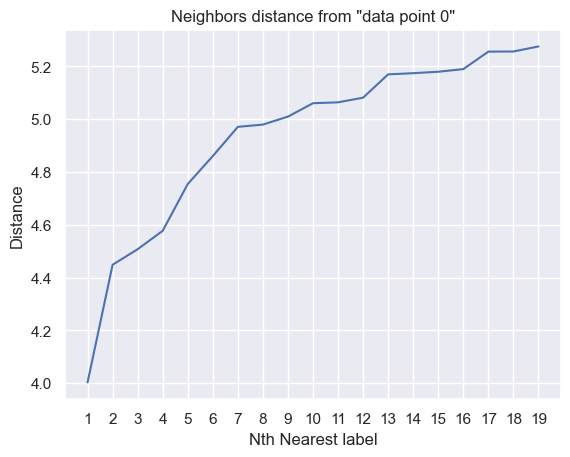

In [85]:
plt.figure()
plt.plot(np.arange(distance.shape[1],dtype=np.int64)+ 1, distance[0,:])
plt.xlabel('Nth Nearest label')
plt.xticks(np.arange(distance.shape[1],dtype=np.int64) + 1)
plt.ylabel('Distance')
plt.title('Neighbors distance from "data point 0"')
plt.show()


### Calculate rho ffor each data point

In [86]:
rhos = distance[:,0]
print(rhos[:5])

[4.0025387 6.093434  1.645424  5.8200917 2.2051282]


In [87]:
# set parameter value for binary search
BIN_ITER=64
GAMMA_TOL=1e-5

# log target is same everywhere
log_target = np.log2(N_NEAREST_NEIGHBORS)

In [88]:
# get the current value for 0th row
curr_val = distance[0,:]

# set the sigma min, max and mid values
sigma_min = 0
sigma_max = np.inf
sigma_mid = 1

n_iter = 1

while n_iter < BIN_ITER:
    # calculate the differance between current distance from 0
    dist_diff = curr_val - rhos[0]

    # calculate the sigma sum 
    sigma_sum = np.sum(np.exp(-(dist_diff)/sigma_mid))

    n_iter += 1

    # break the loop if sigma is equal to target
    if np.abs(log_target - sigma_sum) <= GAMMA_TOL:
        break

    # if sigma sum is greater than log_target
    if sigma_sum > log_target:
        sigma_max = sigma_sum
        sigma_mid = (sigma_max + sigma_min)/2
    else:
        sigma_min = sigma_mid
        if sigma_max == np.inf:
            sigma_mid = 2*sigma_mid
        else:
            sigma_mid = (sigma_max + sigma_min)/2

print('Obtained Sigma Sum: {}'.format(sigma_sum))
print('Target Sigma Sum : {}'.format(log_target))
print('Value of Sigma is : {}'.format(sigma_mid))


Obtained Sigma Sum: 17.038291931152344
Target Sigma Sum : 4.321928094887363
Value of Sigma is : 8.519145965576172


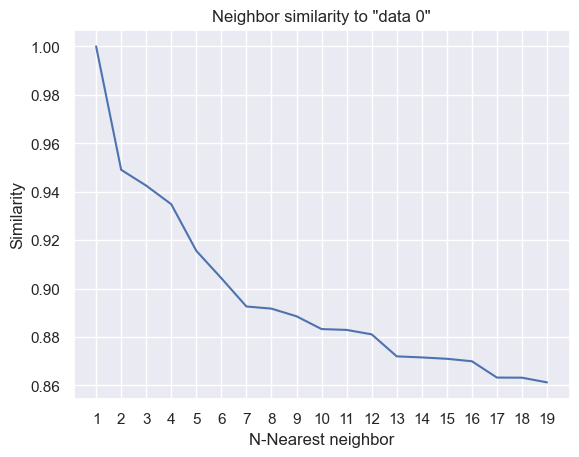

In [89]:
sim_1 = np.exp(-(curr_val - rhos[0])/(sigma_mid))

plt.figure()
plt.plot(np.arange(distance.shape[1], dtype=np.int32)+1, sim_1)
plt.xlabel('N-Nearest neighbor')
plt.xticks(np.arange(distance.shape[1], dtype=np.int32)+1)
plt.ylabel('Similarity')
plt.title('Neighbor similarity to "data 0"')
plt.show()

In [90]:
# wrap binary search into a function
def binary_search_for_sigma(curr_dist, curr_rho, log_target, binary_iter, smooth_k_tolerance):
    # set the sigma min, max and mid values
    sigma_min = 0
    sigma_max = np.inf
    sigma_mid = 1

    n_iter = 1

    for _ in  range(binary_iter):
        # calculate the differance between current distance from 0
        dist_diff = curr_dist - curr_rho

        # calculate the sigma sum 
        sigma_sum = np.sum(np.exp(-(dist_diff)/sigma_mid))

        n_iter += 1

        # break the loop if sigma is equal to target
        if np.abs(log_target - sigma_sum) <= smooth_k_tolerance:
            break

        # if sigma sum is greater than log_target
        if sigma_sum > log_target:
            sigma_max = sigma_sum
            sigma_mid = (sigma_max + sigma_min)/2
        else:
            sigma_min = sigma_mid
            if sigma_max == np.inf:
                sigma_mid = 2*sigma_mid
            else:
                sigma_mid = (sigma_max + sigma_min)/2
    
    return sigma_mid

In [91]:
# calculate sigma value for each sample
sigma_values = np.zeros(distance.shape[0])

for i in range(distance.shape[0]):
    sigma_values[i] = binary_search_for_sigma(
        curr_dist=distance[i:],
        curr_rho=rhos[i],
        log_target=log_target,
        binary_iter=BIN_ITER,
        smooth_k_tolerance=GAMMA_TOL
    )
    print('Total iter : {}/{}'.format(i+1,distance.shape[0]),end='\r')

In [111]:
# store the sample and neighbors for sparse matrix calculation
n_samples = neighbors.shape[0]
n_neighbors = neighbors.shape[1]

# initialize the row and col array 
# this will be later used to symetrize
# the smooth decay matrics
row_mtx = np.zeros(neighbors.size, dtype=np.int32)  # stores the row indexs
col_mtx = np.zeros(neighbors.size, dtype=np.int32)  # store the ids of neighbors
sim_mtx = np.zeros(neighbors.size, dtype=np.float32) # stores the similarity values for each neighbor

# iterate for every sample
for i in range(n_samples):
    # iterate for every neighbor to calculate similarity
    for j in range(n_neighbors):

        # calculate the similarity value
        val = np.exp(-(distance[i,j] - rhos[i]) / sigma_values[i])
        row_mtx[i*n_neighbors + j] = i
        col_mtx[i*n_neighbors + j] = neighbors[i,j]
        sim_mtx[i*n_neighbors + j] = val

    print('Samples calculated / Total Samples : {}/{}'.format(i+1,n_samples),end='\r')

In [112]:
# Create a sparse matrix of smooth distances
# this distance is not yet symmetric
non_sym_sim_mtx = scipy.sparse.coo_matrix((sim_mtx,(row_mtx, col_mtx)),
                                        shape=(neighbors.shape[0], neighbors.shape[0]))
non_sym_sim_mtx.eliminate_zeros()

In [113]:
# transpose the non symmetric similarity matrix
non_sym_sim_mtx_t = non_sym_sim_mtx.transpose()

# get the product of the matrix
prod_sim_mtx = non_sym_sim_mtx.multiply(non_sym_sim_mtx_t)

# calculate the symmetric matrix using fuzzy set relation
sym_sim_mtx = non_sym_sim_mtx + non_sym_sim_mtx_t - prod_sim_mtx

# eliminate the zeros
sym_sim_mtx.eliminate_zeros()

In [114]:
# transform sparse to coordinate formate
sym_sim_mtx = sym_sim_mtx.tocoo()

In [115]:
# return to old format
sym_mtx_row_ids = sym_sim_mtx.row
sym_mtx_col_ids = sym_sim_mtx.col
sym_mtx_vals = sym_sim_mtx.data

In [116]:
# show how indexs and coordinates look like 
# also show identity of each index for both (samples and neighbors)

test = pd.DataFrame(
    np.column_stack([sym_mtx_row_ids,sym_mtx_col_ids,sym_mtx_vals]),
    columns=['rows', 'cols', 'similarities']
)

n_labels = mnist_label.reset_index(drop=True)
row_labels = n_labels[sym_mtx_row_ids]
cols_labels = n_labels[sym_mtx_col_ids]

test.head()

,rows,cols,similarities
0,0.0,13.0,0.999998
1,0.0,333.0,1.000000
2,0.0,443.0,0.999993
3,0.0,814.0,1.000000
4,0.0,1055.0,0.999993
